In [2]:
import pandas as pd

# Charger le fichier CSV
df = pd.read_csv("../data/winsorized_data.csv")

# Afficher les 5 premières lignes
df.head()



,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
0,b'1',b'1',22.830137,b'0',b'1',b'0',b'1',b'1',b'1',b'0',...,b'1',7.20,1.338760,5.38,35.0,19.0,51.0,32.0,999.0,0.0
1,b'1',b'0',23.342466,b'0',b'1',b'0',b'-1',b'-1',b'1',b'0',...,b'1',4.50,11.078295,0.41,20.6,16.0,37.0,1000000.0,163.0,1.0
2,b'1',b'0',26.394521,b'0',b'1',b'0',b'-1',b'-1',b'1',b'0',...,b'1',7.94,14.130301,0.42,23.4,23.0,20.0,1000000.0,435.0,1.0
3,b'0',b'0',39.684932,b'1',b'1',b'0',b'1',b'2',b'1',b'1',...,b'?',4.25,14.130301,0.17,50.0,23.0,29.0,19.0,53.0,1.0
4,b'0',b'1',33.358904,b'0',b'0',b'0',b'1',b'2',b'0',b'1',...,b'1',34.10,3.972255,12.23,10.5,14.0,14.0,1000000.0,2043.0,0.0


La distribution des classes 

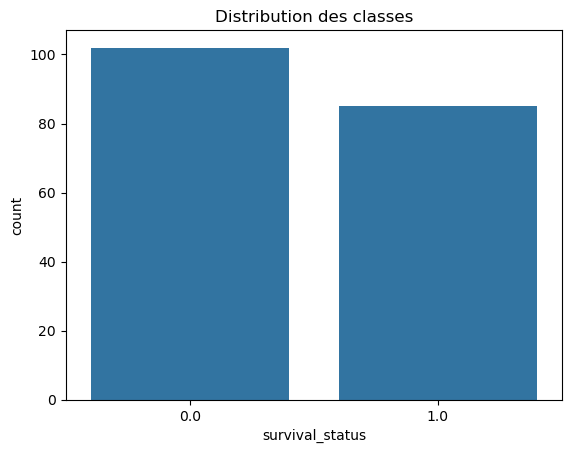

survival_status
0.0    0.545455
1.0    0.454545
Name: proportion, dtype: float64

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vérification de la répartition des classes
sns.countplot(x=df["survival_status"])
plt.title("Distribution des classes")
plt.show()

# Calcul des proportions
df["survival_status"].value_counts(normalize=True)


Oversampling (SMOTE)



In [5]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Step 1: Confirm your data is clean and ready
# All features should now be numeric with no missing values
X_imputed = df.copy()
X_imputed = X_imputed.apply(pd.to_numeric, errors='coerce').fillna(0)
y = X_imputed['survival_status']
X_imputed = X_imputed.drop(columns=['survival_status'])

print("Shape of cleaned dataset:", X_imputed.shape)

# Step 2: Split the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Check class distribution before SMOTE
print("Original class distribution in training set:")
print(pd.Series(y_train).value_counts())

# Step 4: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Verify the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Step 6: Now your resampled data is ready for model training

Shape of cleaned dataset: (187, 36)
Original class distribution in training set:
survival_status
0.0    81
1.0    68
Name: count, dtype: int64
Class distribution after SMOTE:
survival_status
1.0    81
0.0    81
Name: count, dtype: int64


Undersampling Implementation


In [6]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Split the cleaned data first
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Check class distribution before undersampling
print("Original class distribution in training set:")
print(pd.Series(y_train).value_counts())

# Apply Random Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Verify the class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_train_undersampled).value_counts())

# Now your undersampled data is ready for model training
# model.fit(X_train_undersampled, y_train_undersampled)

Original class distribution in training set:
survival_status
0.0    81
1.0    68
Name: count, dtype: int64
Class distribution after undersampling:
survival_status
0.0    68
1.0    68
Name: count, dtype: int64


Class-weight Adjustment Implementation


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier  # Example classifier

# Split the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Check class distribution
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts())

# Compute class weights (automatically handles imbalance)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weight_dict)

# Train model with class weights
# Example with Random Forest (replace with your preferred model)
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight=class_weight_dict  # Apply the class weights here
)

# Fit the model with original (imbalanced) data
model.fit(X_train, y_train)

# No need for resampling with this approach

Class distribution in training set:
survival_status
0.0    81
1.0    68
Name: count, dtype: int64
Class weights: {0.0: 0.9197530864197531, 1.0: 1.0955882352941178}


RandomForestClassifier(class_weight={0.0: 0.9197530864197531,
                                     1.0: 1.0955882352941178},
                       random_state=42)

Comparative Analysis Framework


Correlation

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif

# Assuming you have your data stored in X_imputed and y
# If X_imputed is not a DataFrame, convert it to one for better feature management
if not isinstance(X_imputed, pd.DataFrame):
    # If you have feature names stored separately, use them
    # Otherwise, use placeholder names
    feature_names = [f"feature_{i}" for i in range(X_imputed.shape[1])]
    X_df = pd.DataFrame(X_imputed, columns=feature_names)
else:
    X_df = X_imputed.copy()

# Step 1: Calculate correlation matrix
correlation_matrix = X_df.corr()

# Step 2: Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.close()

# Step 3: Identify highly correlated features
# Define a threshold for high correlation
correlation_threshold = 0.8

# Create a dictionary to store highly correlated pairs
high_corr_pairs = {}

# Find feature pairs with correlation above threshold
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        feature_i = correlation_matrix.columns[i]
        feature_j = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) >= correlation_threshold:
            high_corr_pairs[(feature_i, feature_j)] = correlation

# Display highly correlated pairs
print(f"Number of highly correlated feature pairs (|r| >= {correlation_threshold}): {len(high_corr_pairs)}")
for pair, corr in high_corr_pairs.items():
    print(f"{pair[0]} and {pair[1]}: {corr:.4f}")

# Step 4: Feature selection strategy based on correlation
# Create a set to store features to drop
features_to_drop = set()

# Identify features to drop based on correlation
for (feature1, feature2), corr in high_corr_pairs.items():
    # Calculate the average correlation of each feature with all other features
    avg_corr1 = correlation_matrix[feature1].abs().mean()
    avg_corr2 = correlation_matrix[feature2].abs().mean()
    
    # Drop the feature with higher average correlation
    if avg_corr1 > avg_corr2:
        features_to_drop.add(feature1)
    else:
        features_to_drop.add(feature2)

print(f"\nFeatures to drop based on correlation: {features_to_drop}")

# Step 5: Univariate feature selection to validate our correlation-based approach
# Use SelectKBest with f_classif (ANOVA F-value) for feature ranking
selector = SelectKBest(f_classif, k='all')
selector.fit(X_df, y)
feature_scores = pd.DataFrame({
    'Feature': X_df.columns,
    'F_Score': selector.scores_,
    'P_Value': selector.pvalues_
})

# Sort features by F-score (higher is better)
feature_scores = feature_scores.sort_values('F_Score', ascending=False)
print("\nFeature ranking based on F-scores:")
print(feature_scores)

# Step 6: Make final feature selection recommendations
print("\nFinal Feature Selection Recommendations:")
for feature in features_to_drop:
    # Check if the feature is among the top features based on F-score
    rank = feature_scores[feature_scores['Feature'] == feature].index[0]
    total_features = len(feature_scores)
    percentile = (rank / total_features) * 100
    
    if percentile <= 25:  # If in top 25% of features
        print(f"- {feature}: Consider keeping despite correlation (ranked {rank+1}/{total_features}, " 
              f"top {percentile:.1f}% based on F-score)")
    else:
        print(f"- {feature}: Recommended to drop (ranked {rank+1}/{total_features}, " 
              f"correlation redundancy)")

# Step 7: Create a clean dataset with selected features
X_selected = X_df.drop(columns=list(features_to_drop))
print(f"\nOriginal feature count: {X_df.shape[1]}")
print(f"Selected feature count: {X_selected.shape[1]}")

# Step 8: Document the correlation analysis and feature selection strategy
correlation_analysis_doc = """
# Correlation Analysis and Feature Selection Strategy

## Methodology
1. Calculated Pearson correlation coefficients between all feature pairs
2. Identified highly correlated feature pairs (|r| >= {threshold})
3. For each highly correlated pair, selected one feature to drop based on average correlation with other features
4. Validated selection decisions using univariate feature importance (F-score)
5. Made final recommendations considering both correlation and feature importance

## Results
- Original feature count: {original_count}
- Features removed due to high correlation: {removed_count}
- Final feature count: {final_count}

## Clinical Considerations
- Feature selection was based on statistical correlation and univariate importance
- Clinical domain knowledge should be applied to review these recommendations
- Features with high clinical relevance may be retained despite statistical correlation

## Next Steps
- Review feature selection with clinical experts
- Proceed with model training using the selected feature set
- Document the rationale for any clinically important features that were retained despite high correlation
""".format(
    threshold=correlation_threshold,
    original_count=X_df.shape[1],
    removed_count=len(features_to_drop),
    final_count=X_selected.shape[1]
)

print("\nCorrelation Analysis Documentation:")
print(correlation_analysis_doc)

# Return the selected features dataset for further analysis
X_selected.head()

Number of highly correlated feature pairs (|r| >= 0.8): 1
Recipientage and Rbodymass: 0.9098

Features to drop based on correlation: {'Rbodymass'}

Feature ranking based on F-scores:
                 Feature     F_Score       P_Value
35         survival_time  286.238320  2.056671e-39
33           PLTrecovery   25.224806  1.195864e-06
30           CD3dkgx10d8   10.558422  1.373879e-03
31             Rbodymass    9.458852  2.419907e-03
22          Recipientage    7.840899  5.650130e-03
29              CD3dCD34    5.698003  1.799222e-02
28           CD34kgx10d6    4.665119  3.206796e-02
34  time_to_aGvHD_III_IV    1.891444  1.707023e-01
32           ANCrecovery    1.784016  1.832978e-01
2               Donorage    0.527322  4.686526e-01
0        Recipientgender         NaN           NaN
1         Stemcellsource         NaN           NaN
3             Donorage35         NaN           NaN
4                   IIIV         NaN           NaN
5            Gendermatch         NaN           NaN
6

c:\Users\imadb\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25
 26 27] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\imadb\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,Relapse,aGvHDIIIIV,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time
0,0.0,0.0,22.830137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.20,1.338760,5.38,19.0,51.0,32.0,999.0
1,0.0,0.0,23.342466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.50,11.078295,0.41,16.0,37.0,1000000.0,163.0
2,0.0,0.0,26.394521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.94,14.130301,0.42,23.0,20.0,1000000.0,435.0
3,0.0,0.0,39.684932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.25,14.130301,0.17,23.0,29.0,19.0,53.0
4,0.0,0.0,33.358904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,34.10,3.972255,12.23,14.0,14.0,1000000.0,2043.0


Evaluating RandomForestClassifier


Evaluating: Baseline

Baseline Results:
AUC-ROC: 0.9132
Balanced Accuracy: 0.9118

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93        21
         1.0       1.00      0.82      0.90        17

    accuracy                           0.92        38
   macro avg       0.94      0.91      0.92        38
weighted avg       0.93      0.92      0.92        38


Confusion Matrix:
[[21  0]
 [ 3 14]]

Evaluating: SMOTE

SMOTE Results:
AUC-ROC: 0.9244
Balanced Accuracy: 0.9118

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93        21
         1.0       1.00      0.82      0.90        17

    accuracy                           0.92        38
   macro avg       0.94      0.91      0.92        38
weighted avg       0.93      0.92      0.92        38


Confusion Matrix:
[[21  0]
 [ 3 14]]

Evaluating: Undersampling

Undersampling Results:
AUC-ROC: 0.

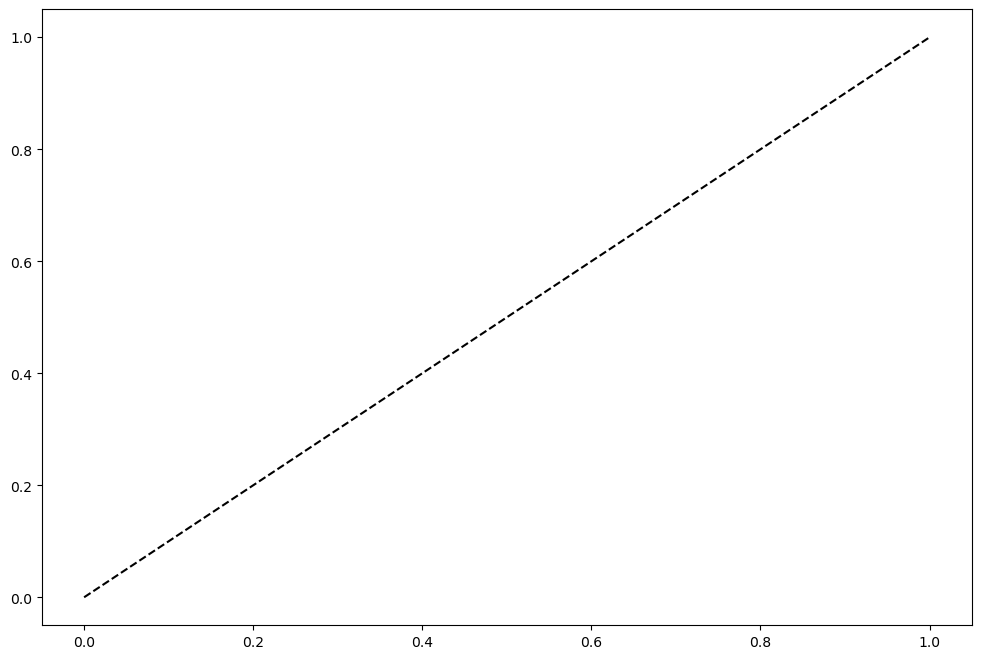

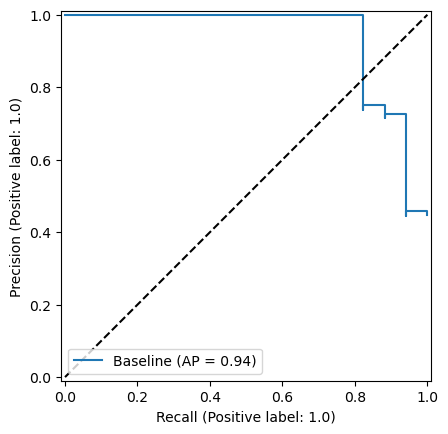

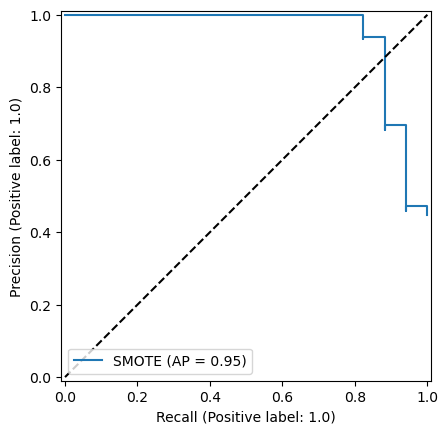

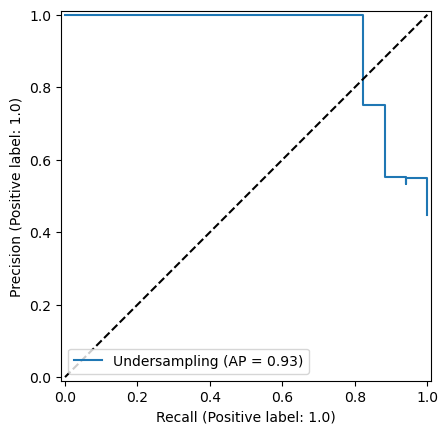

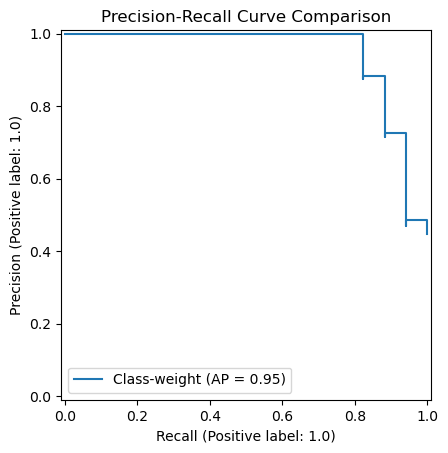

In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, 
                            roc_auc_score, 
                            balanced_accuracy_score,
                            confusion_matrix,
                            PrecisionRecallDisplay)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

def evaluate_model(X_train, y_train, X_test, y_test, model_name):
    """Enhanced evaluation function with better metrics tracking"""
    
    models = {}
    print(f"\n{'='*40}\nEvaluating: {model_name}\n{'='*40}")
    
    # Model training with different strategies
    if model_name == "SMOTE":
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X_train, y_train)
        model = RandomForestClassifier(random_state=42)
        
    elif model_name == "Undersampling":
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X_train, y_train)
        model = RandomForestClassifier(random_state=42)
        
    elif model_name == "Class-weight":
        classes = np.unique(y_train)
        weights = compute_class_weight('balanced', classes=classes, y=y_train)
        class_weights = dict(zip(classes, weights))
        model = RandomForestClassifier(random_state=42, class_weight=class_weights)
        X_res, y_res = X_train, y_train  # No resampling
        
    elif model_name == "Baseline":
        model = RandomForestClassifier(random_state=42)
        X_res, y_res = X_train, y_train  # Original data
    
    # Common training procedure
    model.fit(X_res, y_res)
    
    # Enhanced evaluation metrics
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    
    # Classification metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    auc_roc = roc_auc_score(y_test, y_proba)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Store results
    metrics = {
        'model_name': model_name,
        'model': model,
        'classification_report': report,
        'auc_roc': auc_roc,
        'balanced_accuracy': balanced_acc,
        'confusion_matrix': cm
    }
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(cm)
    
    return metrics

# Usage example
methods = ["Baseline", "SMOTE", "Undersampling", "Class-weight"]
results = {}

for method in methods:
    results[method] = evaluate_model(X_train, y_train, X_test, y_test, method)

# Visual comparison
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot([0, 1], [0, 1], 'k--')
    PrecisionRecallDisplay.from_estimator(
        results[method]['model'], 
        X_test, 
        y_test, 
        name=method
    )
plt.title('Precision-Recall Curve Comparison')
plt.show()

Evaluating XGBoost 


Evaluating XGBoost with Baseline

Method: Baseline
AUC-ROC: 0.9216
Balanced Accuracy: 0.8936

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        21
         1.0       0.88      0.88      0.88        17

    accuracy                           0.89        38
   macro avg       0.89      0.89      0.89        38
weighted avg       0.89      0.89      0.89        38


Confusion Matrix:
[[19  2]
 [ 2 15]]

Evaluating XGBoost with SMOTE

Method: SMOTE
AUC-ROC: 0.9244
Balanced Accuracy: 0.8936

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        21
         1.0       0.88      0.88      0.88        17

    accuracy                           0.89        38
   macro avg       0.89      0.89      0.89        38
weighted avg       0.89      0.89      0.89        38


Confusion Matrix:
[[19  2]
 [ 2 15]]

Evaluating XGBoost with Undersampling



<Figure size 1200x800 with 0 Axes>

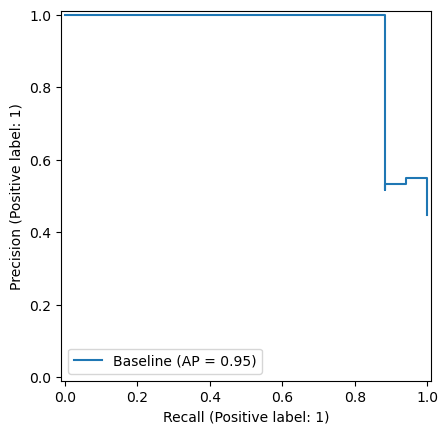

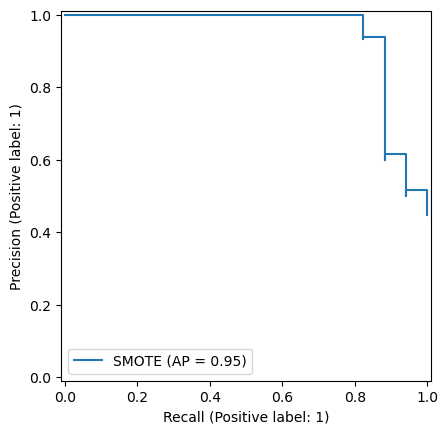

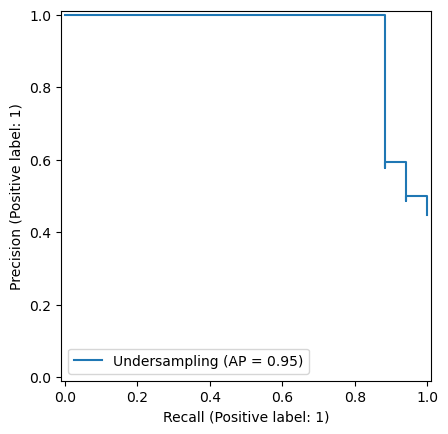

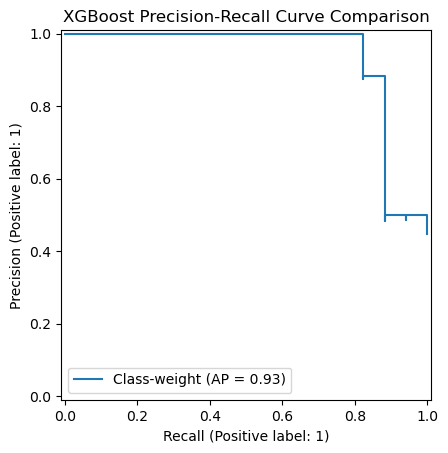

<Figure size 1000x600 with 0 Axes>

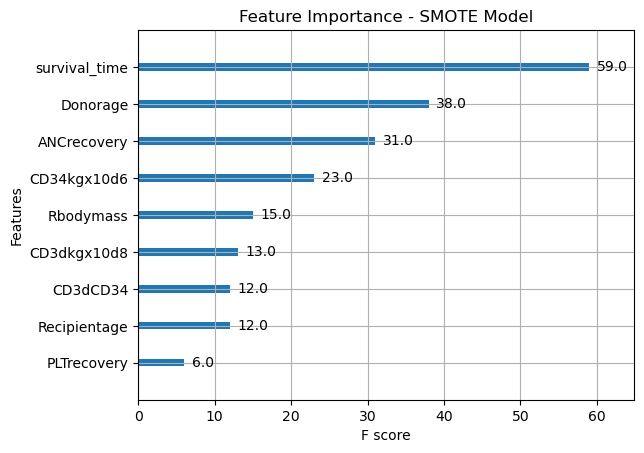

In [10]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import (classification_report, 
                            roc_auc_score,
                            balanced_accuracy_score,
                            confusion_matrix,
                            PrecisionRecallDisplay)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

def evaluate_xgb_model(X_train, y_train, X_test, y_test, method):
    """Enhanced XGBoost evaluation with medical performance metrics"""
    
    print(f"\n{'='*40}\nEvaluating XGBoost with {method}\n{'='*40}")
    
    # Handle class imbalance
    if method == "Baseline":
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=42,
            eval_metric='logloss',
            scale_pos_weight=1  # Default no weighting
        )
        model.fit(X_train, y_train)
        
    elif method == "Class-weight":
        # Calculate appropriate scale_pos_weight
        ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=42,
            eval_metric='logloss',
            scale_pos_weight=ratio
        )
        model.fit(X_train, y_train)
        
    elif method == "SMOTE":
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_train, y_train)
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=42,
            eval_metric='logloss'
        )
        model.fit(X_res, y_res)
        
    elif method == "Undersampling":
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X_train, y_train)
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=42,
            eval_metric='logloss'
        )
        model.fit(X_res, y_res)
    
    # Generate predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate medical performance metrics
    metrics = {
        'auc_roc': roc_auc_score(y_test, y_proba),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }
    
    # Print detailed report
    print(f"\nMethod: {method}")
    print(f"AUC-ROC: {metrics['auc_roc']:.4f}")
    print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])
    
    return model, metrics

# Compare different methods
methods = ["Baseline", "SMOTE", "Undersampling", "Class-weight"]
results = {}

for method in methods:
    model, metrics = evaluate_xgb_model(X_train, y_train, X_test, y_test, method)
    results[method] = {
        'model': model,
        'metrics': metrics
    }

# Visual comparison of precision-recall curves
plt.figure(figsize=(12, 8))
for method in methods:
    PrecisionRecallDisplay.from_estimator(
        results[method]['model'],
        X_test,
        y_test,
        name=method
    )
plt.title('XGBoost Precision-Recall Curve Comparison')
plt.show()

# Feature importance for best performing model
best_method = max(results, key=lambda x: results[x]['metrics']['auc_roc'])
plt.figure(figsize=(10, 6))
xgb.plot_importance(results[best_method]['model'], max_num_features=15)
plt.title(f'Feature Importance - {best_method} Model')
plt.show()

Evaluating SVM


Evaluating SVM with Baseline

Method: Baseline
AUC-ROC: 0.7759
Balanced Accuracy: 0.5042

Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.71      0.62        21
         1.0       0.45      0.29      0.36        17

    accuracy                           0.53        38
   macro avg       0.51      0.50      0.49        38
weighted avg       0.51      0.53      0.51        38


Confusion Matrix:
[[15  6]
 [12  5]]

Evaluating SVM with SMOTE

Method: SMOTE
AUC-ROC: 0.7787
Balanced Accuracy: 0.5042

Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.71      0.62        21
         1.0       0.45      0.29      0.36        17

    accuracy                           0.53        38
   macro avg       0.51      0.50      0.49        38
weighted avg       0.51      0.53      0.51        38


Confusion Matrix:
[[15  6]
 [12  5]]

Evaluating SVM with Undersampling

Method: Unde

<Figure size 1200x800 with 0 Axes>

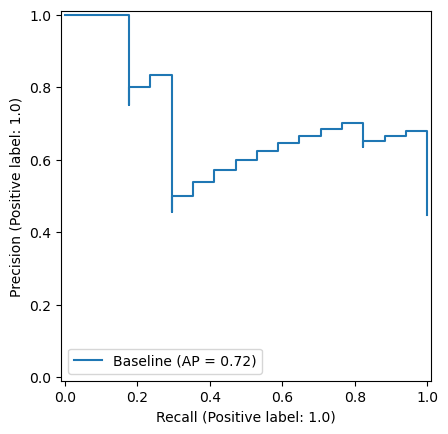

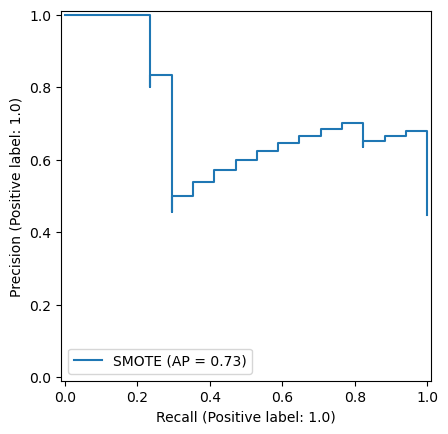

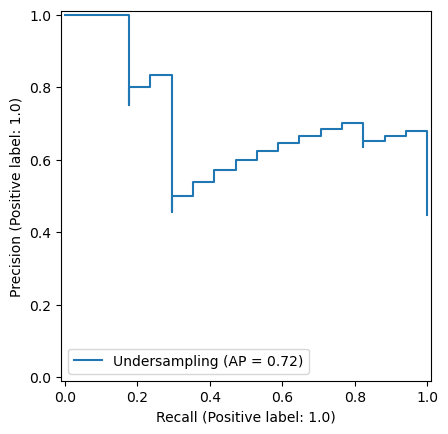

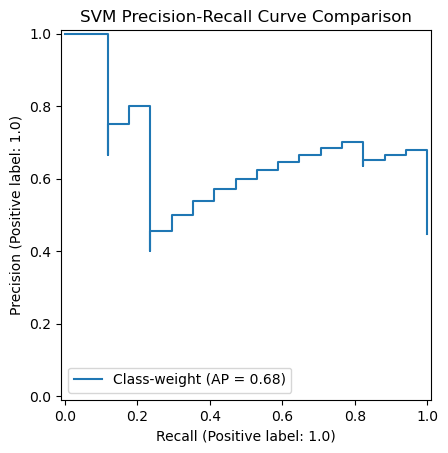

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, 
                            roc_auc_score,
                            balanced_accuracy_score,
                            confusion_matrix,
                            PrecisionRecallDisplay)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np

def evaluate_svm_model(X_train, y_train, X_test, y_test, method):
    """SVM comparative analysis with medical performance metrics"""
    
    print(f"\n{'='*40}\nEvaluating SVM with {method}\n{'='*40}")
    
    # Handle class imbalance
    if method == "Baseline":
        model = SVC(
            kernel='rbf',
            probability=True,
            random_state=42
        )
        
    elif method == "Class-weight":
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        model = SVC(
            kernel='rbf',
            probability=True,
            random_state=42,
            class_weight={0: class_weights[0], 1: class_weights[1]}
        )
        
    elif method == "SMOTE":
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        model = SVC(
            kernel='rbf',
            probability=True,
            random_state=42
        )
        
    elif method == "Undersampling":
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)
        model = SVC(
            kernel='rbf',
            probability=True,
            random_state=42
        )
    
    # Train model
    model.fit(X_train, y_train)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate medical performance metrics
    metrics = {
        'auc_roc': roc_auc_score(y_test, y_proba),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }
    
    # Print detailed report
    print(f"\nMethod: {method}")
    print(f"AUC-ROC: {metrics['auc_roc']:.4f}")
    print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])
    
    return model, metrics

# Compare different methods
methods = ["Baseline", "SMOTE", "Undersampling", "Class-weight"]
results = {}

for method in methods:
    model, metrics = evaluate_svm_model(X_train, y_train, X_test, y_test, method)
    results[method] = {
        'model': model,
        'metrics': metrics
    }

# Visual comparison of precision-recall curves
plt.figure(figsize=(12, 8))
for method in methods:
    PrecisionRecallDisplay.from_estimator(
        results[method]['model'],
        X_test,
        y_test,
        name=method
    )
plt.title('SVM Precision-Recall Curve Comparison')
plt.show()

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, 
                            balanced_accuracy_score,
                            precision_score,
                            recall_score,
                            f1_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

def evaluate_model(X_train, y_train, X_test, y_test, model, model_name):
    """Evaluate a model and return performance metrics"""
    
    # Train model
    model.fit(X_train, y_train)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'AUC-ROC': roc_auc_score(y_test, y_proba),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    
    return metrics

# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

# Define imbalance handling methods
methods = {
    'Baseline': {'resampler': None, 'class_weight': None},
    'Class-weight': {'resampler': None, 'class_weight': 'balanced'},
    'SMOTE': {'resampler': SMOTE(random_state=42), 'class_weight': None},
    'Undersampling': {'resampler': RandomUnderSampler(random_state=42), 'class_weight': None}
}

# Initialize results storage
results = []

# Perform comparative analysis
for method_name, method_params in methods.items():
    print(f"\nEvaluating {method_name}...")
    
    # Prepare data
    if method_params['resampler']:
        X_res, y_res = method_params['resampler'].fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    
    # Evaluate each model
    for model_name, model in models.items():
        # Set class weights if specified
        if method_params['class_weight']:
            if hasattr(model, 'set_params'):
                model.set_params(class_weight=method_params['class_weight'])
        
        # Evaluate and store results
        metrics = evaluate_model(X_res, y_res, X_test, y_test, model, model_name)
        metrics['Method'] = method_name
        results.append(metrics)

# Create comparison table
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df[['Method', 'Model', 'AUC-ROC', 'Balanced Accuracy', 
                               'Precision', 'Recall', 'F1-Score']]

# Display formatted table
print("\nModel Comparison Table:")
print(comparison_df.to_markdown(index=False))

# Save to CSV
comparison_df.to_csv('model_comparison.csv', index=False)


Evaluating Baseline...
[LightGBM] [Info] Number of positive: 68, number of negative: 81
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 149, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.456376 -> initscore=-0.174941
[LightGBM] [Info] Start training from score -0.174941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

c:\Users\imadb\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:14:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 68, number of negative: 81
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 149, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Users\imadb\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:14:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 81, number of negative: 81
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 162, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

c:\Users\imadb\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:14:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


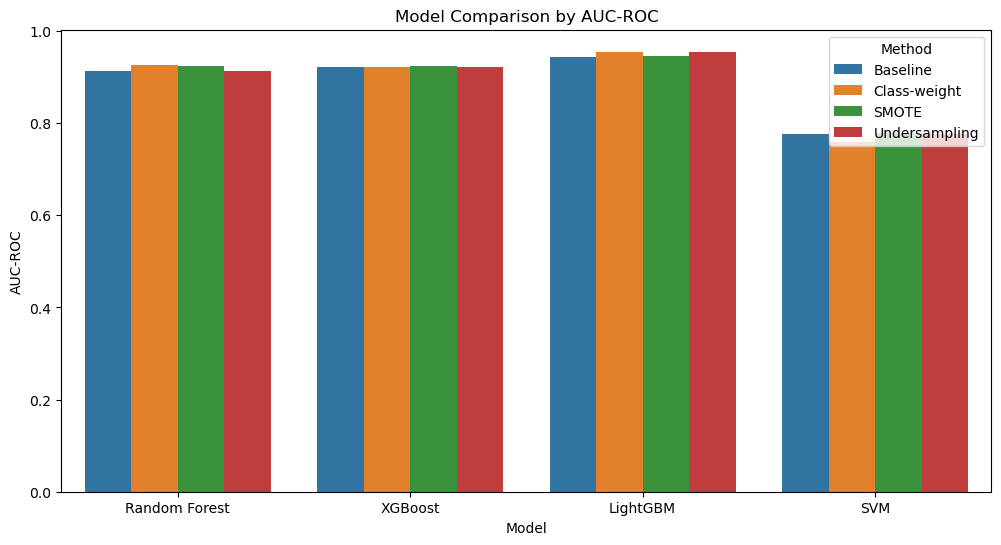

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='AUC-ROC', hue='Method', data=comparison_df)
plt.title('Model Comparison by AUC-ROC')
plt.show()

In [14]:
best_model = comparison_df.loc[comparison_df['AUC-ROC'].idxmax()]
print("\nBest Performing Model:")
print(best_model)


Best Performing Model:
Method               Class-weight
Model                    LightGBM
AUC-ROC                  0.955182
Balanced Accuracy        0.887955
Precision                0.933333
Recall                   0.823529
F1-Score                    0.875
Name: 6, dtype: object


In [328]:
import pandas as pd

# Charger vos données
df = pd.read_csv('winsorized_data.csv')

# Afficher les premières lignes
print(df.head())

  Recipientgender Stemcellsource   Donorage Donorage35  IIIV Gendermatch  \
0            b'1'           b'1'  22.830137       b'0'  b'1'        b'0'   
1            b'1'           b'0'  23.342466       b'0'  b'1'        b'0'   
2            b'1'           b'0'  26.394521       b'0'  b'1'        b'0'   
3            b'0'           b'0'  39.684932       b'1'  b'1'        b'0'   
4            b'0'           b'1'  33.358904       b'0'  b'0'        b'0'   

  DonorABO RecipientABO RecipientRh ABOmatch  ... extcGvHD CD34kgx10d6  \
0     b'1'         b'1'        b'1'     b'0'  ...     b'1'        7.20   
1    b'-1'        b'-1'        b'1'     b'0'  ...     b'1'        4.50   
2    b'-1'        b'-1'        b'1'     b'0'  ...     b'1'        7.94   
3     b'1'         b'2'        b'1'     b'1'  ...     b'?'        4.25   
4     b'1'         b'2'        b'0'     b'1'  ...     b'1'       34.10   

    CD3dCD34 CD3dkgx10d8 Rbodymass ANCrecovery PLTrecovery  \
0   1.338760        5.38      35.0  

In [340]:
import pandas as pd
import numpy as np

def optimize_memory(df):
    """
    Optimise la mémoire d'un DataFrame en ajustant les types de données.
    """
    # Sauvegarder la mémoire initiale
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2  # Mémoire en MB
    
    # Optimiser les types de données
    for col in df.columns:
        col_type = df[col].dtype
        
        # Optimiser les colonnes numériques
        if col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo('int8').min and c_max < np.iinfo('int8').max:
                df[col] = df[col].astype('int8')
            elif c_min > np.iinfo('int16').min and c_max < np.iinfo('int16').max:
                df[col] = df[col].astype('int16')
            elif c_min > np.iinfo('int32').min and c_max < np.iinfo('int32').max:
                df[col] = df[col].astype('int32')
        
        # Optimiser les colonnes catégorielles
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
    
    # Sauvegarder la mémoire finale
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2  # Mémoire en MB
    reduction = 100 * (start_mem - end_mem) / start_mem
    
    print(f"Mémoire initiale : {start_mem:.2f} MB")
    print(f"Mémoire après optimisation : {end_mem:.2f} MB")
    print(f"Réduction de mémoire : {reduction:.2f}%")
    
    return df

In [344]:
# Charger vos données
df = pd.read_csv('winsorized_data.csv')

# Afficher la mémoire avant optimisation
print("Avant optimisation :")
print(df.info(memory_usage='deep'))

# Appliquer l'optimisation
df_optimized = optimize_memory(df)

# Afficher la mémoire après optimisation
print("\nAprès optimisation :")
print(df_optimized.info(memory_usage='deep'))

Avant optimisation :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Recipientgender       187 non-null    object 
 1   Stemcellsource        187 non-null    object 
 2   Donorage              187 non-null    float64
 3   Donorage35            187 non-null    object 
 4   IIIV                  187 non-null    object 
 5   Gendermatch           187 non-null    object 
 6   DonorABO              187 non-null    object 
 7   RecipientABO          187 non-null    object 
 8   RecipientRh           187 non-null    object 
 9   ABOmatch              187 non-null    object 
 10  CMVstatus             187 non-null    object 
 11  DonorCMV              187 non-null    object 
 12  RecipientCMV          187 non-null    object 
 13  Disease               187 non-null    object 
 14  Riskgroup             187 non-null    object 
 15  Tx

Optimisation de la Mémoire

In [350]:
import pandas as pd
import joblib

# -------------------------------------------------
# 1. Charger les données (exemple)
# -------------------------------------------------
df = pd.read_csv("winsorized_data.csv")

# Afficher mémoire avant optimisation
print(f"Mémoire initiale : {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# -------------------------------------------------
# 2. Optimiser les types de données
# -------------------------------------------------
def optimize_memory(df):
    for col in df.columns:
        col_type = df[col].dtype
        
        # Optimiser les nombres
        if col_type == "int64":
            df[col] = pd.to_numeric(df[col], downcast="integer")
        elif col_type == "float64":
            df[col] = pd.to_numeric(df[col], downcast="float")
        
        # Optimiser les chaînes de caractères
        if df[col].dtype == "object":
            df[col] = df[col].astype("category")
    
    return df

df_optimized = optimize_memory(df)

# Afficher mémoire après optimisation
print(f"Mémoire optimisée : {df_optimized.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Sauvegarder les données optimisées
df_optimized.to_csv("dataset_optimized.csv", index=False)

Mémoire initiale : 0.26 MB
Mémoire optimisée : 0.02 MB


In [379]:
# 1. Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import joblib
import gc
import matplotlib.pyplot as plt
import shap
import os

# 2. Chargement des données (ajustez le chemin selon votre configuration)
# Remplacez 'path_to_your_dataset.csv' par le chemin réel de votre jeu de données
df = pd.read_csv('winsorized_data.csv')

# 3. Préparation des données
X = df.drop('survival_status', axis=1)  # Remplacez 'target_column' par le nom de votre variable cible
y = df['survival_status']

# 4. Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Application de SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 6. Optimisation de la mémoire
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Mémoire utilisée au départ: {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mémoire utilisée après optimisation: {:.2f} MB'.format(end_mem))
    print('Réduction de {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Optimisation de la mémoire pour les données d'entraînement
X_train_smote_optimized = reduce_mem_usage(pd.DataFrame(X_train_smote, columns=X.columns))

# 7. Entraînement du modèle RandomForest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

print("Entraînement du modèle RandomForest...")
rf_model.fit(X_train_smote_optimized, y_train_smote)
print("Entraînement terminé!")

# 8. Évaluation du modèle
y_pred = rf_model.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 9. Sauvegarde du modèle
print("Sauvegarde du modèle...")
# Créer un répertoire pour les modèles s'il n'existe pas
os.makedirs('models', exist_ok=True)
joblib.dump(rf_model, 'models/rf_model_compressed.joblib', compress=3)
print("Modèle sauvegardé avec succès!")

# 10. Création des visualisations SHAP
print("Création des visualisations SHAP...")
# Créer un répertoire pour les visualisations s'il n'existe pas
os.makedirs('visualisations', exist_ok=True)

# Initialiser l'explainer SHAP
explainer = shap.TreeExplainer(rf_model)

# Échantillonner les données de test pour des raisons de performance
X_test_sample = X_test.sample(min(1000, len(X_test)), random_state=42)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(X_test_sample)

# Vérifier si shap_values est une liste (cas multi-classes) ou un tableau
if isinstance(shap_values, list):
    print(f"Nombre de classes détectées: {len(shap_values)}")
    
    # Pour la classification binaire, nous utilisons généralement la classe positive (1)
    class_idx = 1 if len(shap_values) > 1 else 0
    
    # Afficher et sauvegarder le Summary Plot (beeswarm)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values[class_idx], X_test_sample, show=False)
    plt.tight_layout()
    plt.savefig('visualisations/shap_summary_beeswarm.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Afficher et sauvegarder le Bar Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values[class_idx], X_test_sample, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig('visualisations/shap_summary_bar.png', dpi=300, bbox_inches='tight')
    plt.close()
else:
    # Pour les modèles à classe unique
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.tight_layout()
    plt.savefig('visualisations/shap_summary_beeswarm.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig('visualisations/shap_summary_bar.png', dpi=300, bbox_inches='tight')
    plt.close()

# Sauvegarde de l'explainer SHAP pour une utilisation ultérieure
joblib.dump(explainer, 'models/shap_explainer.joblib', compress=3)

print("Visualisations SHAP créées et sauvegardées dans le dossier 'visualisations'!")

# 11. Libération de la mémoire
del X_train, X_test, y_train, y_test, X_train_smote, y_train_smote, X_train_smote_optimized
gc.collect()
print("Mémoire libérée!")

print("Processus terminé avec succès!")

ValueError: could not convert string to float: "b'1'"

In [381]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import joblib
import gc
import matplotlib.pyplot as plt
import shap
import os

# Chargement des données (ajustez le chemin selon votre configuration)
# Remplacez 'path_to_your_dataset.csv' par le chemin réel de votre jeu de données
df = pd.read_csv('winsorized_data.csv')

# Affichage des informations sur les types de données
print(df.info())

# Vérification des valeurs uniques dans chaque colonne
for col in df.columns:
    print(f"\nColonne: {col}")
    print(f"Type: {df[col].dtype}")
    print(f"Exemple de valeurs: {df[col].head(3).tolist()}")
    print(f"Nombre de valeurs uniques: {df[col].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Recipientgender       187 non-null    object 
 1   Stemcellsource        187 non-null    object 
 2   Donorage              187 non-null    float64
 3   Donorage35            187 non-null    object 
 4   IIIV                  187 non-null    object 
 5   Gendermatch           187 non-null    object 
 6   DonorABO              187 non-null    object 
 7   RecipientABO          187 non-null    object 
 8   RecipientRh           187 non-null    object 
 9   ABOmatch              187 non-null    object 
 10  CMVstatus             187 non-null    object 
 11  DonorCMV              187 non-null    object 
 12  RecipientCMV          187 non-null    object 
 13  Disease               187 non-null    object 
 14  Riskgroup             187 non-null    object 
 15  Txpostrelapse         1

In [383]:
# Conversion des colonnes binaires
for col in df.columns:
    # Vérification si la colonne contient des valeurs de type b'1' ou b'0'
    if df[col].dtype == 'object':
        try:
            # Tentative de conversion des valeurs binaires
            df[col] = df[col].str.replace("b'", "").str.replace("'", "").astype(float)
        except:
            # Si la conversion échoue, nous laissons la colonne telle quelle pour l'instant
            pass

# Vérification des types de données après conversion
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Recipientgender       187 non-null    float64
 1   Stemcellsource        187 non-null    float64
 2   Donorage              187 non-null    float64
 3   Donorage35            187 non-null    float64
 4   IIIV                  187 non-null    float64
 5   Gendermatch           187 non-null    float64
 6   DonorABO              187 non-null    float64
 7   RecipientABO          187 non-null    object 
 8   RecipientRh           187 non-null    object 
 9   ABOmatch              187 non-null    object 
 10  CMVstatus             187 non-null    object 
 11  DonorCMV              187 non-null    object 
 12  RecipientCMV          187 non-null    object 
 13  Disease               187 non-null    object 
 14  Riskgroup             187 non-null    float64
 15  Txpostrelapse         1

In [385]:
# Identification des colonnes catégorielles
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Encodage des variables catégorielles
from sklearn.preprocessing import LabelEncoder

encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

print("Encodage terminé pour les colonnes catégorielles.")

Encodage terminé pour les colonnes catégorielles.


In [389]:
# Préparation des données
X = df.drop('survival_status', axis=1)  # Remplacez 'target_column' par le nom de votre variable cible
y = df['survival_status']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Application de SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Application de SMOTE réussie !")

Application de SMOTE réussie !


In [391]:
# 6. Optimisation de la mémoire
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Mémoire utilisée au départ: {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mémoire utilisée après optimisation: {:.2f} MB'.format(end_mem))
    print('Réduction de {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Optimisation de la mémoire pour les données d'entraînement
X_train_smote_optimized = reduce_mem_usage(pd.DataFrame(X_train_smote, columns=X.columns))

# 7. Entraînement du modèle RandomForest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

print("Entraînement du modèle RandomForest...")
rf_model.fit(X_train_smote_optimized, y_train_smote)
print("Entraînement terminé!")

# 8. Évaluation du modèle
y_pred = rf_model.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 9. Sauvegarde du modèle
print("Sauvegarde du modèle...")
# Créer un répertoire pour les modèles s'il n'existe pas
os.makedirs('models', exist_ok=True)
joblib.dump(rf_model, 'models/rf_model_compressed.joblib', compress=3)
print("Modèle sauvegardé avec succès!")

# 10. Création des visualisations SHAP
print("Création des visualisations SHAP...")
# Créer un répertoire pour les visualisations s'il n'existe pas
os.makedirs('visualisations', exist_ok=True)

# Initialiser l'explainer SHAP
explainer = shap.TreeExplainer(rf_model)

# Échantillonner les données de test pour des raisons de performance
X_test_sample = X_test.sample(min(1000, len(X_test)), random_state=42)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(X_test_sample)

# Vérifier si shap_values est une liste (cas multi-classes) ou un tableau
if isinstance(shap_values, list):
    print(f"Nombre de classes détectées: {len(shap_values)}")
    
    # Pour la classification binaire, nous utilisons généralement la classe positive (1)
    class_idx = 1 if len(shap_values) > 1 else 0
    
    # Afficher et sauvegarder le Summary Plot (beeswarm)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values[class_idx], X_test_sample, show=False)
    plt.tight_layout()
    plt.savefig('visualisations/shap_summary_beeswarm.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Afficher et sauvegarder le Bar Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values[class_idx], X_test_sample, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig('visualisations/shap_summary_bar.png', dpi=300, bbox_inches='tight')
    plt.close()
else:
    # Pour les modèles à classe unique
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.tight_layout()
    plt.savefig('visualisations/shap_summary_beeswarm.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig('visualisations/shap_summary_bar.png', dpi=300, bbox_inches='tight')
    plt.close()

# Sauvegarde de l'explainer SHAP pour une utilisation ultérieure
joblib.dump(explainer, 'models/shap_explainer.joblib', compress=3)

print("Visualisations SHAP créées et sauvegardées dans le dossier 'visualisations'!")

# 11. Libération de la mémoire
del X_train, X_test, y_train, y_test, X_train_smote, y_train_smote, X_train_smote_optimized
gc.collect()
print("Mémoire libérée!")

print("Processus terminé avec succès!")

Mémoire utilisée au départ: 0.04 MB
Mémoire utilisée après optimisation: 0.01 MB
Réduction de 73.1%
Entraînement du modèle RandomForest...
Entraînement terminé!
Accuracy: 0.9736842105263158

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        22
         1.0       1.00      0.94      0.97        16

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.97      0.97      0.97        38


Confusion Matrix:
[[22  0]
 [ 1 15]]
Sauvegarde du modèle...
Modèle sauvegardé avec succès!
Création des visualisations SHAP...
Visualisations SHAP créées et sauvegardées dans le dossier 'visualisations'!
Mémoire libérée!
Processus terminé avec succès!


In [353]:
pip install streamlit